In [6]:
pip install optuna scikit-learn xgboost lightgbm catboost numpy pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 6.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [catboost]3/5 [plotly]]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from lightgbm import LGBMRegressor


from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
from sklearn.metrics import mean_absolute_error

In [3]:
preprocessed_dataset = pd.read_csv("../data/pre-processed/preprocessed_youtube_data.csv")

In [4]:
preprocessed_dataset.head()

category_id  view_count_initial  like_count_initial  c_view_count_initial  \
0         23.0               313.0                 3.0              785521.0   
1         24.0                 1.0                 0.0              357560.0   
2         20.0                 6.0                 0.0               43478.0   
3         24.0              3257.0                 0.0            34502534.0   
4         24.0               981.0                59.0             4489959.0   

   c_subscriber_count_initial  view_count_final  like_count_final  \
0                   -0.342770             472.0               4.0   
1                   -0.344238               5.0               0.0   
2                   -0.345104              24.0               0.0   
3                   -0.179822            5130.0               0.0   
4                   -0.307319            1211.0              60.0   

   published_year  published_month published_day_of_week published_time  \
0            2025                7              Thursday       19:40:50   
1            2025                7              Thursday       20:12:03   
2            2025                7              Thursday       20:07:08   
3            2025                7              Thursday       19:30:13   
4            2025                7              Thursday       19:47:20   

   view_count_difference  like_count_difference  avg_view_diff_per_category  \
0                  159.0                    1.0                 1012.863636   
1                    4.0                    0.0                 1079.757576   
2                   18.0                    0.0                 7633.540541   
3                 1873.0                    0.0                 1079.757576   
4                  230.0                    1.0                 1079.757576   

   avg_likes_diff_per_category  engagement_score  channel_authority  \
0                    34.636364          0.006289           7.462215   
1                    31.742424          0.000000           6.762730   
2                    38.891892          0.000000           5.852202   
3                    31.742424          0.001602          11.502885   
4                    31.742424          0.017391          10.038936   

   logged_at_initial_hour  logged_at_final_hour  
0                    20.0                  21.0  
1                    20.0                  21.0  
2                    20.0                  21.0  
3                    20.0                  21.0  
4                    20.0                  21.0

In [5]:
preprocessed_dataset.dtypes

category_id                    float64
view_count_initial             float64
like_count_initial             float64
c_view_count_initial           float64
c_subscriber_count_initial     float64
view_count_final               float64
like_count_final               float64
published_year                   int64
published_month                  int64
published_day_of_week           object
published_time                  object
view_count_difference          float64
like_count_difference          float64
avg_view_diff_per_category     float64
avg_likes_diff_per_category    float64
engagement_score               float64
channel_authority              float64
logged_at_initial_hour         float64
logged_at_final_hour           float64
dtype: object

In [6]:
# Convert to datetime if not already
preprocessed_dataset['published_time'] = pd.to_datetime(preprocessed_dataset['published_time'], format='%H:%M:%S', errors='coerce')

# Extract hour and minute
preprocessed_dataset['published_hour'] = preprocessed_dataset['published_time'].dt.hour
preprocessed_dataset['published_minute'] = preprocessed_dataset['published_time'].dt.minute

# Drop the original time column
preprocessed_dataset.drop(columns=['published_time'], inplace=True)

In [7]:
preprocessed_dataset.dtypes

category_id                    float64
view_count_initial             float64
like_count_initial             float64
c_view_count_initial           float64
c_subscriber_count_initial     float64
view_count_final               float64
like_count_final               float64
published_year                   int64
published_month                  int64
published_day_of_week           object
view_count_difference          float64
like_count_difference          float64
avg_view_diff_per_category     float64
avg_likes_diff_per_category    float64
engagement_score               float64
channel_authority              float64
logged_at_initial_hour         float64
logged_at_final_hour           float64
published_hour                   int32
published_minute                 int32
dtype: object

In [8]:
# Initialize label encoder
le = LabelEncoder()

# Apply on 'published_day_of_week'
preprocessed_dataset['published_day_of_week'] = le.fit_transform(preprocessed_dataset['published_day_of_week'])


In [9]:
preprocessed_dataset.dtypes

category_id                    float64
view_count_initial             float64
like_count_initial             float64
c_view_count_initial           float64
c_subscriber_count_initial     float64
view_count_final               float64
like_count_final               float64
published_year                   int64
published_month                  int64
published_day_of_week            int64
view_count_difference          float64
like_count_difference          float64
avg_view_diff_per_category     float64
avg_likes_diff_per_category    float64
engagement_score               float64
channel_authority              float64
logged_at_initial_hour         float64
logged_at_final_hour           float64
published_hour                   int32
published_minute                 int32
dtype: object

In [10]:
missing_mask = preprocessed_dataset[['like_count_initial', 'like_count_final', 'view_count_initial', 'view_count_final']].isnull()

# Check rows where all four columns are NaN
rows_all_nan = missing_mask.all(axis=1)

print("Number of rows with all four columns NaN:", rows_all_nan.sum())

# Optionally, see those rows
print(preprocessed_dataset[rows_all_nan])

Number of rows with all four columns NaN: 11
     category_id  view_count_initial  like_count_initial  \
22           NaN                 NaN                 NaN   
28           NaN                 NaN                 NaN   
32           NaN                 NaN                 NaN   
61           NaN                 NaN                 NaN   
70           NaN                 NaN                 NaN   
83           NaN                 NaN                 NaN   
130          NaN                 NaN                 NaN   
137          NaN                 NaN                 NaN   
179          NaN                 NaN                 NaN   
239          NaN                 NaN                 NaN   
307          NaN                 NaN                 NaN   

     c_view_count_initial  c_subscriber_count_initial  view_count_final  \
22                    NaN                         NaN               NaN   
28                    NaN                         NaN               NaN   
32       

In [11]:
rows_any_nan = missing_mask.any(axis=1)
print("Rows with any of the four columns NaN:", rows_any_nan.sum())

Rows with any of the four columns NaN: 11


In [12]:
preprocessed_dataset = preprocessed_dataset.dropna(subset=[
    'like_count_initial',
    'like_count_final',
    'view_count_initial',
    'view_count_final'
])

In [13]:
# Define target columns
target_columns = [
    'like_count_initial',
    'like_count_final',
    'view_count_initial',
    'view_count_final'
]

In [14]:
# Choose columns to check for outliers, e.g. target columns
cols_to_check = target_columns  # or other numeric features

z_scores = np.abs(stats.zscore(preprocessed_dataset[cols_to_check]))
# Define threshold, e.g. 3 std deviations
threshold = 3
# Keep only rows where all z-scores are below threshold (no outlier)
non_outliers = (z_scores < threshold).all(axis=1)


print(f"Rows before outlier removal: {len(preprocessed_dataset)}")
preprocessed_dataset = preprocessed_dataset[non_outliers]
print(f"Rows after outlier removal: {len(preprocessed_dataset)}")

Rows before outlier removal: 339
Rows after outlier removal: 332


In [16]:
# Separate features and targets
X = preprocessed_dataset.drop(columns=target_columns)
y = preprocessed_dataset[target_columns]

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
initial_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [91]:
base_model = LGBMRegressor(random_state=42)

# Wrap base model with MultiOutputRegressor
model = MultiOutputRegressor(base_model)

In [92]:
param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [5, 10],
    'estimator__min_child_samples': [10, 20]  # replaces min_samples_split
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=kf,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)


In [93]:
grid_search.fit(X_scaled, y)

print("✅ Best Parameters:", grid_search.best_params_)
print("🎯 Best CV Score (neg MAE):", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 11
[LightGBM] [Info] Number of data points in the train set: 266, number

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 11
[LightGBM] [Info] Start training from score 43.498113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 11
[LightGBM] [Info] Start training from score 1174.279245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 11
[LightGBM] [Info] Start training from score 43.498113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 11
[LightGBM] [Info] Start training from score 37.747170
[LightGBM] [Warning] No further spl

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 11
[LightGBM] [Warning] No further splits 

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 503
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 11
[LightGBM] [Info] Start training from score 37.747170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn d

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 11
[LightGBM] [Info] Start training from score 41.936747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


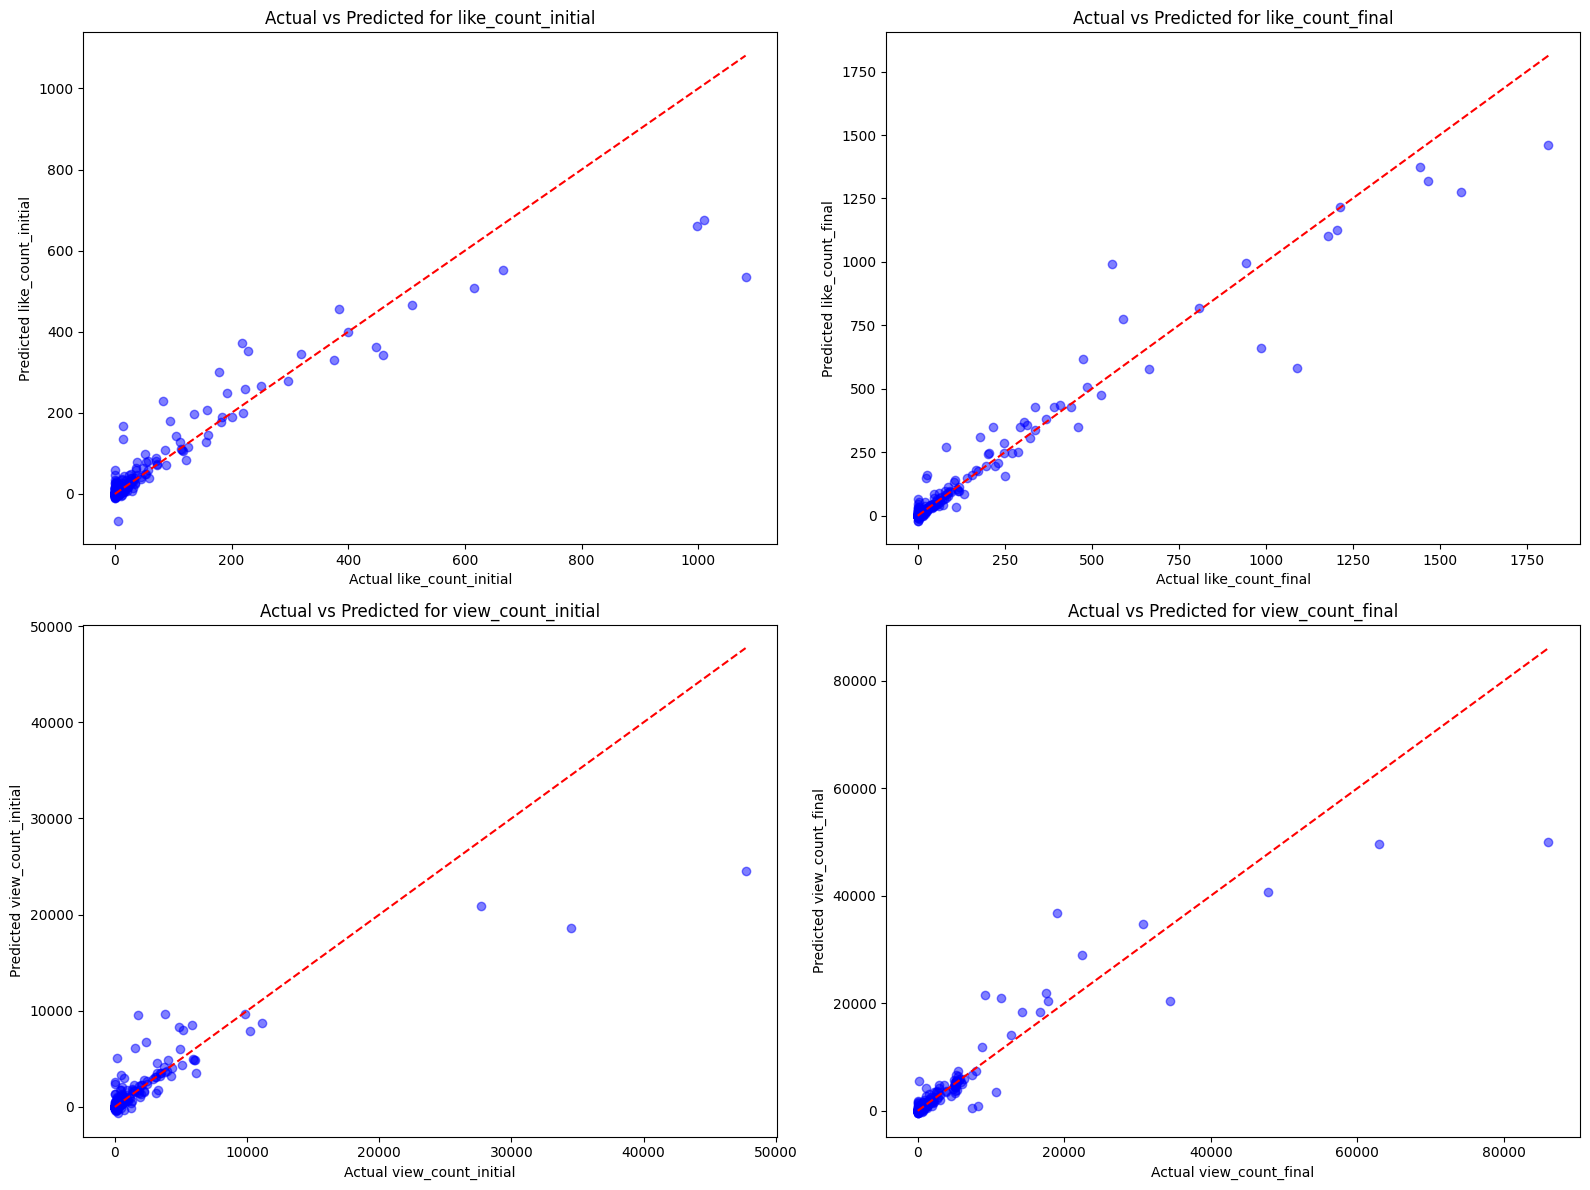

In [ ]:
grid_search.fit(X_scaled, y)

print("✅ Best Parameters:", grid_search.best_params_)
print("🎯 Best CV Score (neg MAE):", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the whole dataset (you can also split into test set if preferred)
y_pred = best_model.predict(X_scaled)

target_names = [
    'like_count_initial',
    'like_count_final',
    'view_count_initial',
    'view_count_final'
]

plt.figure(figsize=(16, 12))

for i, target in enumerate(target_names):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y[target], y_pred[:, i], alpha=0.5, color='blue')
    plt.plot([y[target].min(), y[target].max()],
             [y[target].min(), y[target].max()], 'r--')
    plt.xlabel('Actual ' + target)
    plt.ylabel('Predicted ' + target)
    plt.title(f'Actual vs Predicted for {target}')

plt.tight_layout()
plt.show()

In [96]:
# Get the best model
best_model = grid_search.best_estimator_

# Initialize KFold again (same split)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_per_target = {col: [] for col in target_columns}

# Loop through each fold manually to predict and calculate MAE per target
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model on train split
    best_model.fit(X_train, y_train)
    
    # Predict on test split
    y_pred = best_model.predict(X_test)
    
    # y_pred is numpy array of shape (n_samples, n_targets)
    
    # Calculate MAE for each target column and store
    for i, col in enumerate(target_columns):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mae_per_target[col].append(mae)

# Calculate average MAE per target across folds
avg_mae_per_target = {col: np.mean(maes) for col, maes in mae_per_target.items()}

print("MAE per target variable:")
for col, mae in avg_mae_per_target.items():
    print(f"{col}: {mae:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 11
[LightGBM] [Info] Start training from score 43.498113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/YT-analytics/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(265, 4)

3.0.2
4.6.0
